https://rare-technologies.com/word2vec-tutorial/

lo que hacemos es utilizar una red neuronal para interrelacionar las palabras de un texto.
Como?

usando un autoencoder al que luego quitamos la ultima capa, esto nos da los vectores de cada palabra una red neuronal con n entradas (palabras unicas en el texto), m neuronas en capa intermedia, y o neuronas en la salida. el sistema intenta predecir qué palabra vendrá despues de cada palabra de entrada. siendo la palabra un vector de 1Xn.

el sistema aprenderá que palabras con vectores parecidos estan inter relacionadas (pertenecen al mismo tema)

al cortar la capa final, lo que nos queda es una matriz de datos con la probabilidad de aparicion de una palabra para las demas. eso es un vector

In [16]:
import gensim
import pandas as pd
import pyodbc 


In [ ]:
import configLocal
server = configLocal.server
database = configLocal.database
username = configLocal.username
password = configLocal.password
cnxn = configLocal.cnxn
cursor = cnxn.cursor()

In [ ]:
data = pd.read_sql_query("select msg_id, msg_users_id, msg_timestamp, msg_text from dbo.msg", cnxn)

In [ ]:
data.head()

In [ ]:
data.shape

In [ ]:
corpus = {}
for i in range(data.shape[0]):
    if data.iloc[i]["msg_users_id"] in corpus:
        corpus[data.iloc[i]["msg_users_id"]].append(re.sub(r'http\S+', '', data.iloc[i]["msg_text"], flags=re.MULTILINE))
    else:
        corpus[data.iloc[i]["msg_users_id"]] = [re.sub(r'http\S+', '', data.iloc[i]["msg_text"], flags=re.MULTILINE)]
type(corpus), len(corpus)

In [ ]:
corpus["428308122"]

In [ ]:
for i in corpus.keys():
    corpus[i] = gensim.utils.simple_preprocess("".join(corpus[i]).encode('utf-8'), deacc=True, min_len=3)

In [61]:
corpus["428308122"]

['aritzeta',
 'bibiloni',
 'josepmcld',
 'ratafia_party',
 'jbadia',
 'tambe',
 'pero',
 'diria',
 'que',
 'reflexiu',
 'estar',
 'sobrer',
 'cupriudoms',
 'vist',
 'casualitat',
 'millor',
 'josefina',
 'martonamg',
 'fananwa',
 'quan',
 'fou',
 'mort',
 'combregaren',
 'equival',
 'buenas',
 'horas',
 'mangas',
 'verdes',
 'literaturaimes',
 'enricgoma',
 'martonamg',
 'quan',
 'fou',
 'mort',
 'combregaren',
 'equival',
 'buenas',
 'horas',
 'mangas',
 'verdes',
 'mauletgroc',
 'martonamg',
 'quan',
 'fou',
 'mort',
 'combregaren',
 'equival',
 'buenas',
 'horas',
 'mangas',
 'verdes',
 'trudigonzlezma',
 'martonamg',
 'potser',
 'victoracedoma',
 'bibiloni',
 'josepmcld',
 'ratafia_party',
 'jbadia',
 'fakerragut',
 'romeucarles',
 'vogelfreicat',
 'que']

In [ ]:
#prueba de una lista de listas de strings por usuario
df = []
for i in corpus.keys():
    df.append(corpus[i])

In [19]:
df = []

In [ ]:
for i in corpus.keys():
    for j in corpus[i]:
        df.append(j)

In [ ]:
print("List of lists. Let's confirm: ", type(df), " of ", type(df[0]))

In [20]:
#size: Nª of layers
#window: Maximum distance between the current and predicted word within a sentence
#min_count: nº of times a word repeats to be taken into account
#sg: training algorithm. 0=cbow, 1=skip-gram
#workers: nº of cores running. no cyton installed--> no paralelization

model = gensim.models.Word2Vec(size=150, window=8, min_count=5, sg=1, workers=10)
model.build_vocab(df)  # prepare the model vocabulary

In [81]:
#training the model
model.train(sentences=df, total_examples=len(df), epochs=model.iter)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


(987705, 1478415)

In [83]:
#save the model
model.save('./data/model')

In [21]:
model = Word2Vec.load("./erase")

NameError: name 'Word2Vec' is not defined

In [2]:
word_vectors = model.wv
count = 0
for word in word_vectors.vocab:
    if count<10:
        print(word)
        count += 1
    else:
        break

NameError: name 'model' is not defined

In [ ]:
len(word_vectors.vocab)

In [86]:
print(model.wv.most_similar(positive=["mujer","rey"],negative=["hombre"]))

[('juegan', 0.897331953048706), ('salvo', 0.8857386112213135), ('pudo', 0.884837806224823), ('ganado', 0.8817203044891357), ('muerte', 0.8701326847076416), ('calle', 0.869951605796814), ('siendo', 0.8695622086524963), ('tendria', 0.8689562082290649), ('error', 0.8686603307723999), ('cambio', 0.8672849535942078)]


In [8]:
#now, lets load da big boi model

from numpy import  zeros, float32 as REAL
from gensim.models import keyedvectors
import codecs

# this function was build using code excerpts from:
# https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/keyedvectors.py
def load_vectors_from_csv(fname,vocab_size=973265,vector_size=100):
    print("Loading vectors from file:",fname)
    result=keyedvectors.KeyedVectors(vector_size=100)
    result.syn0 = zeros((vocab_size, vector_size), dtype=REAL)
    result.vector_size=vector_size
    counts=None   
    def add_word(word, weights):
        word_id = len(result.vocab)
        if word in result.vocab:
            print("duplicate word '%s' in %s, ignoring all but first", word, fname)
            return
        if counts is None:
            # most common scenario: no vocab file given. just make up some bogus counts, in descending order
            result.vocab[word] = keyedvectors.Vocab(index=word_id, count=vocab_size - word_id)
        elif word in counts:
            # use count from the vocab file
            result.vocab[word] = keyedvectors.Vocab(index=word_id, count=counts[word])
        else:
            # vocab file given, but word is missing -- set count to None (TODO: or raise?)
            print("vocabulary file is incomplete: '%s' is missing", word)
            result.vocab[word] = keyedvectors.Vocab(index=word_id, count=None)
        result.syn0[word_id] = weights
        result.index2word.append(word)   
    file=codecs.open(fname,"r","utf-8")
    i=0
    for line in file:
        i+=1
        if i==1: #ommit header
            continue
        parts=line.strip().split(",")
        word,weights=parts[1],[REAL(x) for x in parts[2:]]
        add_word(word,weights)
        if i%100000==0:
            print(i,"word vectors loaded so far ...")
    file.close()
    print(i-1,"word vectors loaded!")
    return result
    

    
model=load_vectors_from_csv("data/WORD2VEC-Twitter-Espa_ol_para_Latinoam_rica__Espa_a_y_Estados_Unidos2.csv")

Loading vectors from file: data/WORD2VEC-Twitter-Espa_ol_para_Latinoam_rica__Espa_a_y_Estados_Unidos2.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).


100000 word vectors loaded so far ...
159742 word vectors loaded!


In [13]:
#save the model
model.save('./data/giga-model')

In [36]:
#cual no corresponde?
model.wv.doesnt_match(["pais", "hombre","mujer"])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


'pais'

In [3]:
#extraccion a variable de las palabras y sus vectores
word_vectors = model.wv

#visualizar las 10 primeras
count = 0
for word in word_vectors.vocab:
    if count<10:
        print(word)
        count += 1
    else:
        break

de
que
la
a
y
el
no
en
me
to


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [10]:
#crear una lista de 150 palabras para plotear
wanted_words = []
count = 0
for word in word_vectors.vocab:
    if count<150:
        wanted_words.append(word)
        count += 1
    else:
        break

#crear un diccionario con las palabras y sus vectores
wanted_vocab = dict((k, word_vectors.vocab[k]) for k in wanted_words if k in word_vectors.vocab)
wanted_vocab

{'de': <gensim.models.keyedvectors.Vocab at 0x209f0bb96a0>,
 'que': <gensim.models.keyedvectors.Vocab at 0x209ee539d30>,
 'la': <gensim.models.keyedvectors.Vocab at 0x209f0bb9668>,
 'a': <gensim.models.keyedvectors.Vocab at 0x209ee539da0>,
 'y': <gensim.models.keyedvectors.Vocab at 0x209f0d6b4e0>,
 'el': <gensim.models.keyedvectors.Vocab at 0x209f0d6b6a0>,
 'no': <gensim.models.keyedvectors.Vocab at 0x209f0d6b588>,
 'en': <gensim.models.keyedvectors.Vocab at 0x209f0d6b710>,
 'me': <gensim.models.keyedvectors.Vocab at 0x209f0d6b5f8>,
 'to': <gensim.models.keyedvectors.Vocab at 0x209f0d6b668>,
 'es': <gensim.models.keyedvectors.Vocab at 0x209f0d6b7b8>,
 'replying': <gensim.models.keyedvectors.Vocab at 0x209f0d6b748>,
 'con': <gensim.models.keyedvectors.Vocab at 0x209f0d6b828>,
 'se': <gensim.models.keyedvectors.Vocab at 0x209f0d6b978>,
 'mi': <gensim.models.keyedvectors.Vocab at 0x209f0d6b860>,
 'un': <gensim.models.keyedvectors.Vocab at 0x209f0d6b908>,
 'lo': <gensim.models.keyedvectors

In [11]:
#TSNE permite reducir la dimensionalidad manteniendo las relaciones/proporciones previas
#https://www.datacamp.com/community/tutorials/introduction-t-sne
from sklearn.manifold import TSNE

X = model[wanted_vocab] # X es un array de vectores de palabras, cada vector contiene 150 "tokens"
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
Y = tsne_model.fit_transform(X)

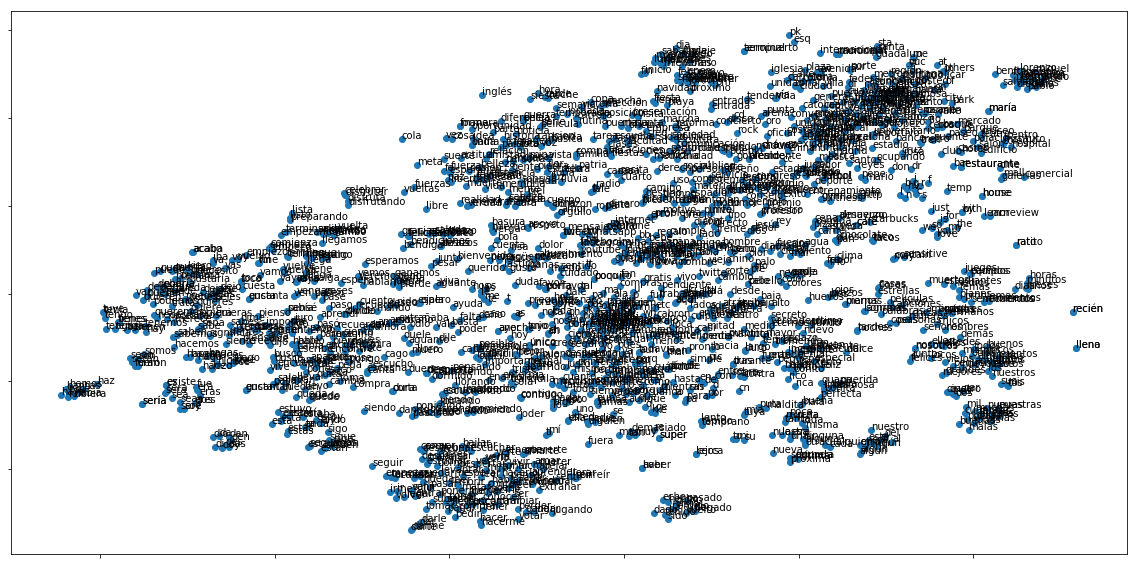

In [12]:
import matplotlib.pyplot as plt


#Plot the t-SNE output
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(Y[:, 0], Y[:, 1])
words = list(wanted_vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(Y[i, 0], Y[i, 1]))
ax.set_yticklabels([]) #Hide ticks
ax.set_xticklabels([]) #Hide ticks
_ = plt.show()